In [409]:
import pandas as pd
import os
import urllib.request
import json
import collections
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('white')
sns.set_context('talk')
%matplotlib inline

In [389]:
# read in json from kimono scraper applied to export feature (https://member.citibikenyc.com/profile/trips/8PYQ2ZZY-1/print)
df = pd.read_json('citibike-data-2017.json', orient='records')
df['duration'] = df.timestamp_end - df.timestamp_start
df.head()

,station_end,station_start,timestamp_duration,timestamp_end,timestamp_start,duration
0,Central Park West & W 100 St,E 11 St & 1 Ave,41 min 33 s,2017-12-23 22:45:10,2017-12-23 22:03:37,00:41:33
1,E 11 St & 1 Ave,W 70 St & Amsterdam Ave,28 min 23 s,2017-12-23 15:43:46,2017-12-23 15:15:23,00:28:23
2,W 100 St & Manhattan Ave,W 53 St & 10 Ave,18 min 32 s,2017-12-23 02:20:56,2017-12-23 02:02:24,00:18:32
3,W 52 St & 9 Ave,Columbus Ave & W 95 St,12 min 55 s,2017-12-22 22:36:18,2017-12-22 22:23:23,00:12:55
4,6 Ave & W 33 St,W 11 St & 6 Ave,17 min 47 s,2017-12-21 18:13:55,2017-12-21 17:56:08,00:17:47


In [39]:
# get station data from citibike
!wget https://member.citibikenyc.com/data/stations.json

--2017-12-28 22:29:18--  https://member.citibikenyc.com/data/stations.json
Resolving member.citibikenyc.com (member.citibikenyc.com)... 216.54.179.38
Connecting to member.citibikenyc.com (member.citibikenyc.com)|216.54.179.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189978 (186K) [application/json]
Saving to: ‘stations.json’

stations.json       100%[===================>] 185.53K   592KB/s    in 0.3s    

2017-12-28 22:29:25 (592 KB/s) - ‘stations.json’ saved [189978/189978]



In [10]:
# nb: removed first and last lines from the json file manually
df_stations = pd.read_json('stations.json', orient='records')

In [11]:
# map stations to latitude and longitude for maps api
df_stations = df_stations[['s', 'la', 'lo']]
df_stations = df_stations.set_index('s')
station2latitude, station2longitude = df_stations.to_dict()['la'], df_stations.to_dict()['lo']

In [12]:
stations = list(set(df.station_end.values).union(df.station_start.values))

In [13]:
rename_dict = dict(zip(stations, stations))
rename_dict.update({'Bond St & Schermerhorn St': 'Schermerhorn St & Bond St',
                   'E 40 St & 5 Ave': 'E 41 St & 5 Ave',
                    'Fulton St & Washington Ave': 'Fulton St & Waverly Ave',
                    'W 14 St & The High Line': 'W 16 St & The High Line',
                    'W 39 St & 9 Ave': 'W 36 St & 9 Ave',
                   })

for column in filter(lambda s: 'station' in s, df.columns):
  df[column] = df[column].map(rename_dict)

In [32]:
for string in ['start', 'end']:
  lat = df['station_%s' % string].map(station2latitude)
  lng = df['station_%s' % string].map(station2longitude)
  df['lat_lng_%s' % string] = lat.astype(str) + ',' + lng.astype(str)

In [169]:
def get_distance_and_duration(trip, mode):
  # maps api can't get historical data; request data a year in the future
  t = trip.timestamp_start + pd.DateOffset(years=1)
  departure_time_utc = t.value // 1000000000
  url = "https://maps.googleapis.com/maps/api/distancematrix/json?origins={}&destinations={}&departure_time={}&mode={}&key={}".format(
            trip.lat_lng_start, trip.lat_lng_end, departure_time_utc, mode, os.environ['GOOGLE_MAPS_API_TOKEN'])
  response = urllib.request.urlopen(url)
  data = json.loads(response.read())
  distance = data['rows'][0]['elements'][0]['distance']['value']
  predicted_duration = data['rows'][0]['elements'][0]['duration']['value']
  return distance, predicted_duration

In [187]:
# manually apply to rows due to bug in pandas apply (https://github.com/pandas-dev/pandas/issues/17892)

for mode in ['driving', 'bicycling', 'subway']:
  distance_durations = []
  for idx in range(len(df)):
    distance_durations.append(get_distance_and_duration(df.loc[idx], mode))
  df['%s_distance' % mode], df['%s_predicted_duration' % mode] = zip(*distance_durations)

In [250]:
df.to_csv('citibike-data-2017-with-distances.csv', index=False)

In [391]:
df = pd.read_csv('citibike-data-2017-with-distances.csv', parse_dates=['timestamp_start', 'timestamp_end'])

In [392]:
df['driving_distance_km'] = df['driving_distance'] / 1000.
df['bicycling_distance_km'] = df['bicycling_distance'] / 1000.

In [393]:
# workouts are where station start and end are the same
travel_mask = df.station_start != df.station_end
df = df[travel_mask]

In [394]:
for column in df.columns:
  if 'duration' in column and column != 'timestamp_duration':
    df['%s_min' % column] = df[column].astype(int) / 60.

In [395]:
df['bicycling_speed'] = df['bicycling_distance_km'] / df['duration_min'] * 60.
# there were 4 trips that were too fast, 
# because they were taken down one-way streets going the wrong way (and google maps assumes you stay safe)
too_fast_indices = df['bicycling_speed'] > 26
df = df[~too_fast_indices]

In [396]:
df.head()

,station_end,station_start,timestamp_duration,timestamp_end,timestamp_start,lat_lng_start,lat_lng_end,driving_distance,driving_predicted_duration,bicycling_distance,...,subway_distance,subway_predicted_duration,duration,driving_distance_km,bicycling_distance_km,driving_predicted_duration_min,bicycling_predicted_duration_min,subway_predicted_duration_min,duration_min,bicycling_speed
0,Central Park West & W 100 St,E 11 St & 1 Ave,41 min 33 s,2017-12-23 22:45:10,2017-12-23 22:03:37,"40.72953837,-73.98426726","40.793393,-73.9635556",10266,1509,8881,...,10266,1509,2493.0,10.266,8.881,25.150000,33.883333,25.150000,41.550000,12.824549
1,E 11 St & 1 Ave,W 70 St & Amsterdam Ave,28 min 23 s,2017-12-23 15:43:46,2017-12-23 15:15:23,"40.77748046,-73.98288594","40.72953837,-73.98426726",7424,1820,7399,...,7424,1820,1703.0,7.424,7.399,30.333333,29.050000,30.333333,28.383333,15.640869
2,W 100 St & Manhattan Ave,W 53 St & 10 Ave,18 min 32 s,2017-12-23 02:20:56,2017-12-23 02:02:24,"40.76669671,-73.99061728","40.795,-73.9645",5201,701,4224,...,5201,701,1112.0,5.201,4.224,11.683333,17.583333,11.683333,18.533333,13.674820
3,W 52 St & 9 Ave,Columbus Ave & W 95 St,12 min 55 s,2017-12-22 22:36:18,2017-12-22 22:23:23,"40.7919557,-73.968087","40.76461837,-73.98789473",3479,696,3479,...,3479,696,775.0,3.479,3.479,11.600000,12.100000,11.600000,12.916667,16.160516
4,6 Ave & W 33 St,W 11 St & 6 Ave,17 min 47 s,2017-12-21 18:13:55,2017-12-21 17:56:08,"40.73532427,-73.99800419","40.74901271,-73.98848395",1749,474,1749,...,1749,474,1067.0,1.749,1.749,7.900000,6.350000,7.900000,17.783333,5.901031


In [397]:
def scatter(x, y):
  fig, ax = plt.subplots(1, figsize=(8 * 1.618, 8))
  df.plot(ax=ax, kind='scatter', x=x, y=y)
  ax.plot(df[x], df[x])
  plt.show()

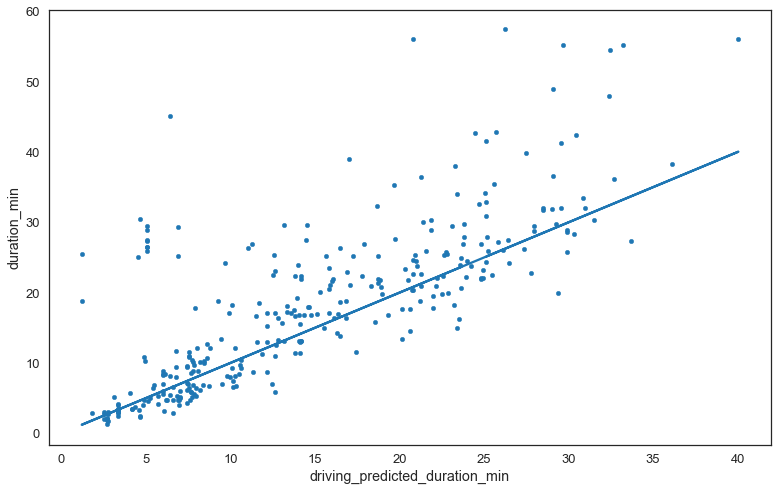

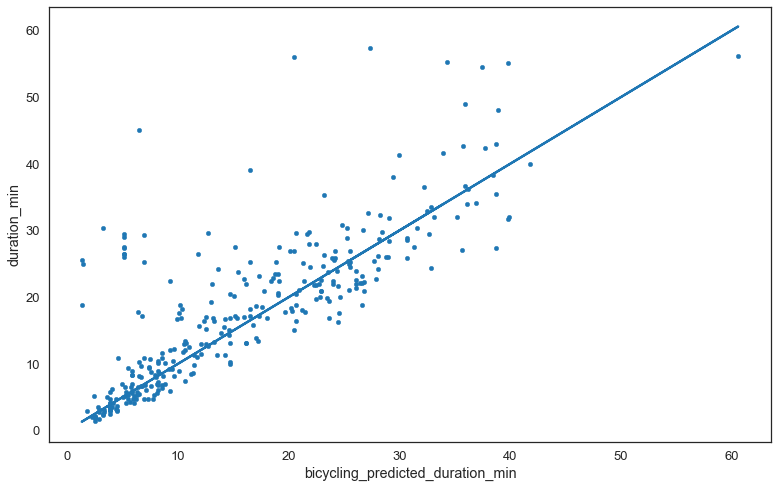

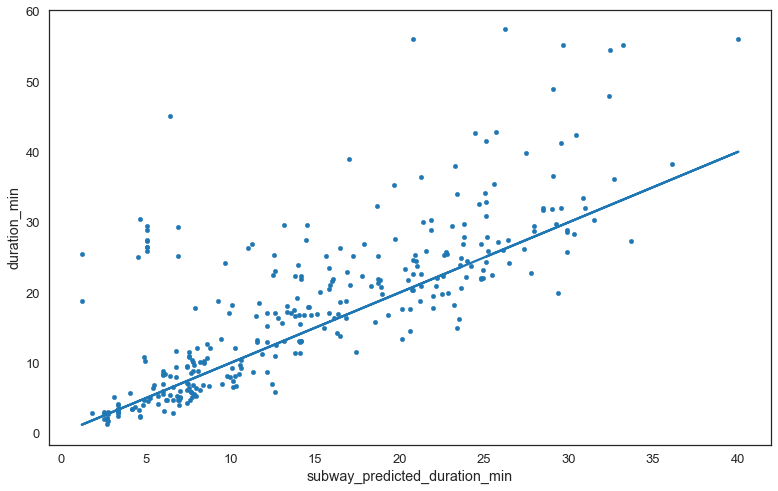

In [410]:
scatter('driving_predicted_duration_min', 'duration_min')
scatter('bicycling_predicted_duration_min', 'duration_min')
scatter('subway_predicted_duration_min', 'duration_min')

In [411]:
faster_than_maps = df.bicycling_predicted_duration_min > df[travel_mask].duration_min
sum(faster_than_maps), len(faster_than_maps)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(152, 318)

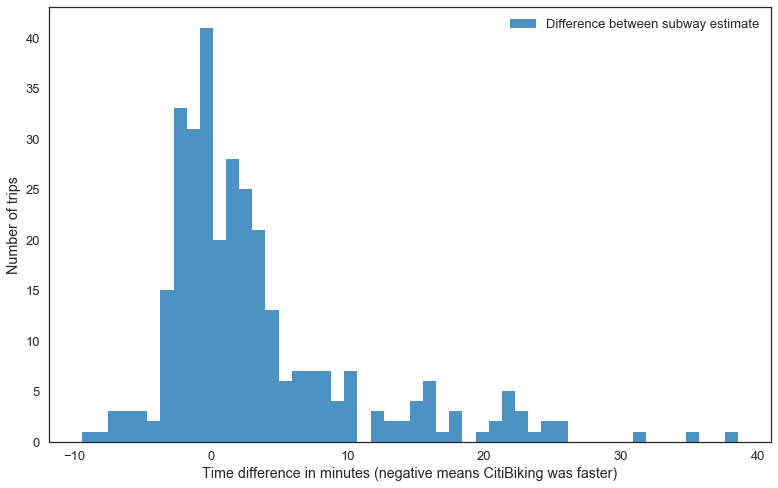

In [412]:
fig, ax = plt.subplots(1, figsize=(8 * 1.618, 8))
ax.hist(df.duration_min - df.subway_predicted_duration_min, bins=50, label='Difference between subway estimate', alpha=0.8)
ax.set(xlabel='Time difference in minutes (negative means CitiBiking was faster)', ylabel='Number of trips')
ax.legend()

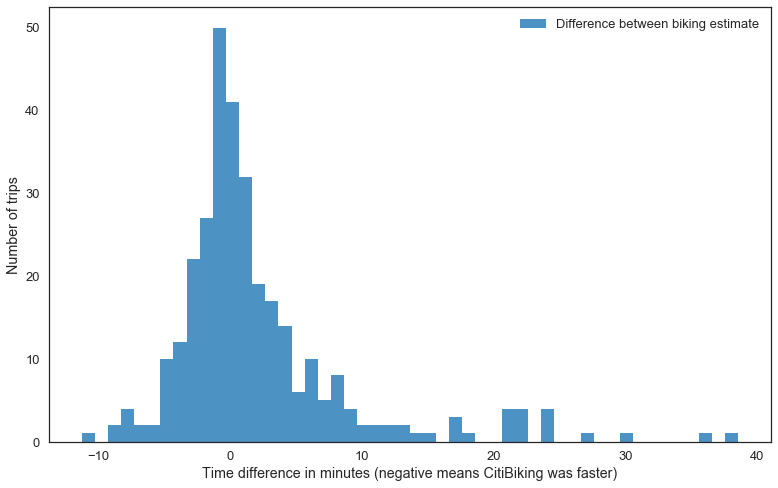

In [413]:
fig, ax = plt.subplots(1, figsize=(8 * 1.618, 8))
ax.hist(df.duration_min - df.bicycling_predicted_duration_min, bins=50, label='Difference between biking estimate', alpha=0.8)
ax.set(xlabel='Time difference in minutes (negative means CitiBiking was faster)', ylabel='Number of trips')
ax.legend()

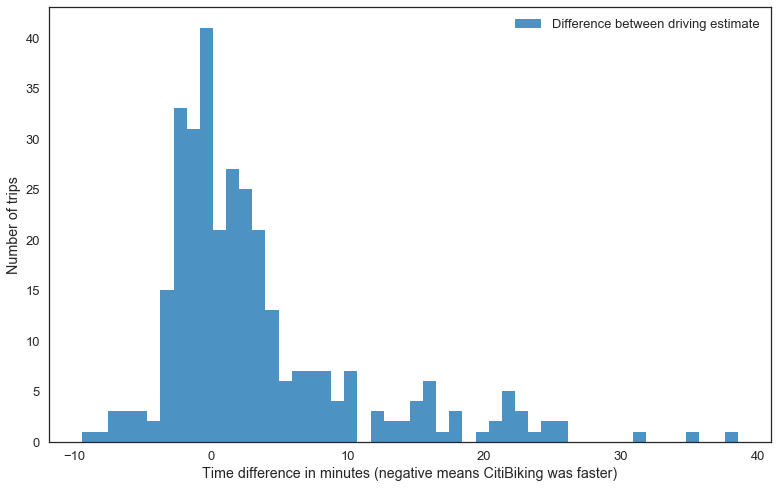

In [414]:
fig, ax = plt.subplots(1, figsize=(8 * 1.618, 8))
ax.hist(df.duration_min - df.driving_predicted_duration_min, bins=50, label='Difference between driving estimate', alpha=0.8)
ax.set(xlabel='Time difference in minutes (negative means CitiBiking was faster)', ylabel='Number of trips')
ax.legend()

In [415]:
# average time saved (if positive; it means time was WASTED! lol)
(df.duration_min - df.driving_predicted_duration_min).mean(), (df.duration_min - df.subway_predicted_duration_min).mean(), (df.duration_min - df.bicycling_predicted_duration_min).mean()

(3.383438155136267, 3.38736897274633, 2.143972746331237)

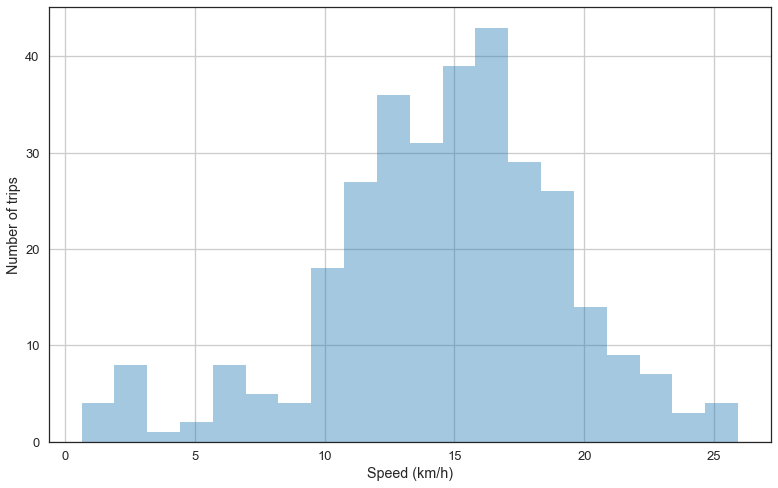

In [424]:
fig, ax = plt.subplots(1, figsize=(8 * 1.618, 8))
sns.distplot(df['bicycling_speed'], kde=False, ax=ax, bins=20)
ax.set(xlabel='Speed (km/h)', ylabel='Number of trips')
ax.grid()
plt.show()
plt.savefig('speed_histogram.png', bbox_inches='tight')

In [420]:
# check that top speeds are reasonable
df[df['bicycling_speed'] > 25]

,station_end,station_start,timestamp_duration,timestamp_end,timestamp_start,lat_lng_start,lat_lng_end,driving_distance,driving_predicted_duration,bicycling_distance,...,subway_distance,subway_predicted_duration,duration,driving_distance_km,bicycling_distance_km,driving_predicted_duration_min,bicycling_predicted_duration_min,subway_predicted_duration_min,duration_min,bicycling_speed
57,E 59 St & Madison Ave,W 37 St & 5 Ave,5 min 55 s,2017-10-05 13:04:45,2017-10-05 12:58:50,"40.75038009,-73.98338988","40.76350532,-73.97109243",2559,758,2556,...,2559,758,355.0,2.559,2.556,12.633333,9.250000,12.633333,5.916667,25.920000
101,Lafayette St & E 8 St,Cathedral Pkwy & Broadway,27 min 25 s,2017-08-08 17:38:44,2017-08-08 17:11:19,"40.804213,-73.96699104","40.7302066053,-73.9910262823",11203,2022,11743,...,11203,2022,1645.0,11.203,11.743,33.700000,38.716667,33.700000,27.416667,25.698967
144,West St & Chambers St,Cathedral Pkwy & Broadway,27 min 8 s,2017-07-06 18:17:00,2017-07-06 17:49:52,"40.804213,-73.96699104","40.71754834,-74.01322069",11614,1551,11671,...,11614,1551,1628.0,11.614,11.671,25.850000,35.616667,25.850000,27.133333,25.808108


In [421]:
# assuming we'd citibike rather than subway for trips greater than 2km (~20min walk)
# subway fare is $2.75
# calculate dollars saved
sum(df['bicycling_distance'] > 2) * 2.75

874.5

In [422]:
# calculate km biked
df['bicycling_distance_km'].sum()

1325.779

In [423]:
df['bicycling_speed'].describe()

count    318.000000
mean      14.647354
std        4.690394
min        0.641933
25%       12.198692
50%       14.885456
75%       17.569807
max       25.920000
Name: bicycling_speed, dtype: float64